In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline
from typing import Union,TypeVar
from datetime import datetime
import joblib
import sys
import json

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

from TRGAN.TRGAN_main_V2 import *
from TRGAN.encoders import *
import TRGAN.TRGAN_train_load_modules as trgan
from TRGAN.evaluation_metrics import *
from TRGAN.methods_comparison import *
from TRGAN.TRGAN_light_preprocessing import *
from TRGAN.data_preprocessing import load_data

# import random

# random.seed(55555)
# np.random.seed(55555)


import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [113]:
# data = load_data(path='Data/', name='czech')
# data = load_data(path='Data/', name='users_spb_only')
data = load_data(path='Data/', name='transaction_secret')
# data = load_data(path='Data/', name='data_uk_clean')

In [114]:
data.head()

,CustomerKey,ID,TRANS_TIME,AMOUNT_EQ,MCC,PAY_AMT,PaymentSystem,TERMINAL_CODE,ADDRESS,TRANS_DETAIL,NAME,OpType,DETAILED_CARD_TYPE,ISOWNTERMINAL,ACCOUNT_ID,CARD,DATE,HOUR,MINUTE,SECOND
0,1005525,394373193,2024-09-03 01:53:39,2000.0,6011,2000.0,MasterCard,AC090347,"РОССИЯ,194356,,,г Санкт-Петербург,ул Бухарестс...","BUKHARESTSKAYA,18, St Petersburg, RU",Выдача наличных ден. средств через банкомат,Снятие наличных,MasterCard Unembossed,True,4351563,3005469,2017-05-01,1,53,39
1,1012091,394372678,2024-09-03 05:23:40,200.0,6011,200.0,MasterCard,AC090350,"РОССИЯ,191002,,,г Санкт-Петербург,ул Большая М...","B.MOSKOVSKAYA,2/1, St Petersburg, RU",Выдача наличных ден. средств через банкомат,Снятие наличных,MasterCard Unembossed,True,1437772,328245,2017-05-01,5,23,40
2,1015672,394556655,2024-09-03 06:57:29,35.0,4111,35.0,MasterCard,MP320200,"РОССИЯ,190000,,,г Санкт-Петербург,пр-кт Обухов...","METRO.SPB.RU, St Petersburg, RU",Оплата товаров/услуг по карте,Оплата,MasterCard Unembossed,True,9385201,3019515,2017-05-01,6,57,29
3,1024107,394370163,2024-09-03 07:26:19,200.0,6011,200.0,MasterCard,AC090253,"РОССИЯ,195299,,,г Санкт-Петербург,пр-кт Гражда...","GRAZHDANSKIY, 131, St Petersburg, RU",Выдача наличных ден. средств через банкомат,Снятие наличных,MasterCard Unembossed,True,1454720,2844003,2017-05-01,7,26,19
4,1024542,394557641,2024-09-03 08:03:35,45.0,4111,45.0,MasterCard,Y3200040,"РОССИЯ,190000,,,г Санкт-Петербург,ул Политехни...","METRO.SPB.RU, St Petersburg, RU",Оплата товаров/услуг по карте,Оплата,MasterCard World,True,1455317,2816034,2017-05-01,8,3,35


In [69]:
# onehot_cols = ['type', 'tcode']
# cat_feat_names = ['account_id', 'description', 'id']
# num_feat_names = ['amount', 'balance']
# log1p_transform_cols = []
# date_feature = 'date'
# time_feature = ''
# client_id = 'account_id'
# mcc_name = 'tcode'

# latent_dim = {'onehot': 20, 'categorical': 6, 'numerical': 6, 'cv': 20}

In [115]:
onehot_cols = ['MCC', 'OpType', 'NAME', 'PaymentSystem', 'ISOWNTERMINAL']
cat_feat_names = ['CustomerKey', 'ID', 'TERMINAL_CODE', 'ADDRESS',\
                'TRANS_DETAIL', 'DETAILED_CARD_TYPE', 'ACCOUNT_ID', 'CARD']

num_feat_names = ['AMOUNT_EQ', 'PAY_AMT', 'HOUR', 'MINUTE', 'SECOND']
log1p_transform_cols = ['AMOUNT_EQ', 'PAY_AMT']
date_feature = 'DATE'
time_feature = 'TRANS_TIME'
client_id = 'CustomerKey'
mcc_name = 'MCC'

latent_dim = {'onehot': 30, 'categorical': 4, 'numerical': 3, 'cv': 20}

In [71]:
# onehot_cols = ['shop']
# cat_feat_names = ['TRANS_DETAIL', 'customer']

# num_feat_names = ['AMOUNT_EQ', 'HOUR', 'MINUTE', 'SECOND']
# log1p_transform_cols = ['AMOUNT_EQ']
# date_feature = 'TRANS_DATE'
# time_feature = 'TRANS_TIME'
# client_id = 'customer'
# mcc_name = 'shop'

# latent_dim = {'onehot': 30, 'categorical': len(cat_feat_names), 'numerical': len(num_feat_names), 'cv': 20}

In [72]:
# cat_feat_names = ['customer']
# onehot_cols = ['mcc']
# num_feat_names = ['amount', 'balance', 'age']
# log1p_transform_cols = ['amount']
# date_feature = 'transaction_date'
# time_feature = ''
# client_id = 'customer'
# mcc_name = 'mcc'

# latent_dim = {'onehot': 20, 'categorical': 2, 'numerical': 2, 'cv': 10}

In [73]:
# normal, sc = prob_int_transform(X_emb[:, latent_dim['onehot']:-latent_dim['numerical']])
# s = synth_data[:, latent_dim['onehot']:-latent_dim['numerical']]
# s = (s - np.mean(s, axis=0)) / np.std(s, axis=0)

# plt.hist(X_emb[:, latent_dim['onehot']:-latent_dim['numerical']][:, 0], bins=60, alpha=0.7)
# plt.hist(s[:, 0], bins=60, alpha=0.7)

# plt.show()

# plt.hist(inverse_prob_int_transform(s, scaler_cat['scaler_01'])[:, 6], bins=60)
# plt.show()

In [116]:
data = log1p_transform(data, log1p_transform_cols)

In [127]:
%%time

X_emb, X_oh, cond_vector, synth_date, scaler_cat, scaler_onehot, scaler_num, cv_params, scaler, round_array = \
            trgan.embeddings(data, cat_feat_names, num_feat_names, onehot_cols, date_feature, time_feature, client_id, latent_dim, device=DEVICE, load=False, epochs=40)

Loss E_num: 0.00016043364303186536: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000334907: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


CPU times: user 8min 46s, sys: 38.3 s, total: 9min 24s
Wall time: 4min 3s


In [128]:
%%time

dim_noise = 20
generator, supervisor, loss_array = trgan.train(X_emb, cond_vector, latent_dim, dim_noise, epochs=40, load=False)

Discriminator Loss: -0.04953 || Discriminator 2 Loss: -0.00180 || Generator Loss: 0.01586 || Supervisor Loss: 0.02748: 100%|██████████| 40/40 [01:20<00:00,  2.01s/it]

CPU times: user 4min 41s, sys: 27.3 s, total: 5min 8s
Wall time: 1min 20s


In [129]:
n_samples = len(X_emb[:])
synth_data, synth_date, params = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, cv_params['encoder'], data,\
                                date_feature, client_id, cv_params=cv_params, device=DEVICE)

X_emb1 = scaler.inverse_transform(X_emb)
synth_data = scaler.inverse_transform(synth_data)

synth_df = inverse_transform(synth_data, latent_dim, X_oh.columns, scaler_onehot, scaler_cat, scaler_num, cat_feat_names,
                             mcc_name, num_feat_names, True, synth_date, time_feature, round_array)

In [130]:
# for i in range(latent_dim['onehot'],X_emb1.shape[1]):
#     plt.hist(X_emb1[:, i], bins=40, alpha=0.7, density=True)
#     plt.hist(synth_data[:, i], bins=40, alpha=0.7, density=True)

#     plt.show()

In [131]:
synth_df.head()

,MCC,OpType,NAME,PaymentSystem,ISOWNTERMINAL,CustomerKey,ID,TERMINAL_CODE,ADDRESS,TRANS_DETAIL,DETAILED_CARD_TYPE,ACCOUNT_ID,CARD,AMOUNT_EQ,PAY_AMT,DATE,TRANS_TIME
0,5641,Оплата,Оплата товаров/услуг по карте,БАНК,True,1002943,605026303,M4800080,"г Санкт-Петербург, пр-кт Ветеранов, 114/4","PULKOVSKOYE SH., 17-2, St Petersburg, RU",MasterCard World,4235675,3253665,7.637649,7.641038,2018-04-03,15:33:33
1,6011,Снятие наличных,Выдача наличных ден. средств через банкомат,MasterCard,True,101275,521817490,AC090543,"РОССИЯ,,обл Калининградская,,г Калининград,ул ...","SESTRORETSK,VOLODARSKOG, SESTRORETSK, RU",MasterCard Unembossed,1433371,2337452,6.617871,6.618508,2017-11-09,12:20:20
2,6011,Снятие наличных,Выдача наличных ден. средств через банкомат,MasterCard,True,1003732,757257370,Y3200104,"198517, Санкт-Петербург, г Петергоф, ш Ропшинс...","OOO ""KLIN EXPERT"", St Petersburg, RU",МИР Детская,1430310,4224862,9.655774,9.659679,2018-12-25,21:58:58
3,6011,Снятие наличных,Выдача наличных ден. средств через банкомат,MasterCard,True,1005988,652864024,MP326326,"РОССИЯ,198184,,,г Санкт-Петербург,остров Канон...","LENINSKIY PR.,125, St Petersburg, RU",Дошкольная карта,598131,3738707,8.169685,8.166289,2018-06-06,16:40:41
4,5722,Оплата,Оплата товаров/услуг по карте,MasterCard,True,1019930,570460347,AC090443,"РОССИЯ,195009,,,г Санкт-Петербург,пл Ленина,до...","PR. NEVSKIY, 35 A, St Petersburg, RU",MasterCard World,3142283,3175965,7.129877,7.124564,2018-01-18,14:27:27


## Evaluation

In [174]:
# X_emb2 = copy.deepcopy(X_emb1)
# temp = copy.deepcopy(X_emb1[:, -3:])
# np.random.shuffle(temp)
# X_emb2[:, -3:] = temp

# synth_df = inverse_transform(X_emb1 + np.random.normal(0, 0.001,size=X_emb1.shape), latent_dim, X_oh.columns, scaler_onehot, scaler_cat, scaler_num, cat_feat_names,
#                              mcc_name, num_feat_names, True, synth_date, time_feature, round_array)

In [175]:
cat_feat_names

['CustomerKey',
 'ID',
 'TERMINAL_CODE',
 'ADDRESS',
 'TRANS_DETAIL',
 'DETAILED_CARD_TYPE',
 'ACCOUNT_ID',
 'CARD']

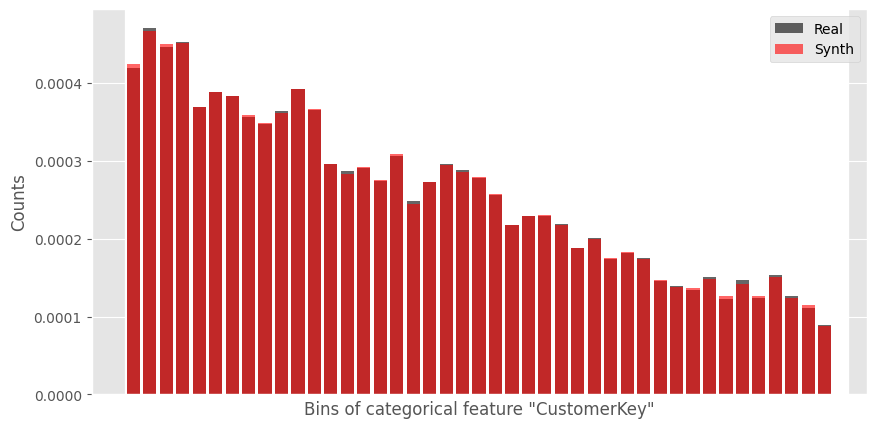

In [176]:
plot_hist_categorical(data, synth_df, client_id, 90)

In [21]:
# data = inverse_log1p_transform(data, log1p_transform_cols)
# synth_df = inverse_log1p_transform(synth_df, log1p_transform_cols)

In [177]:
num_feat_names

['AMOUNT_EQ', 'PAY_AMT', 'HOUR', 'MINUTE', 'SECOND']

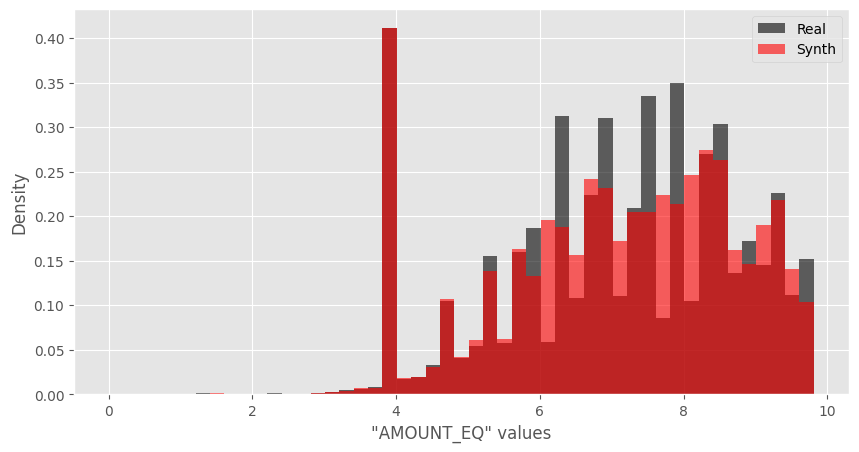

In [178]:
plot_hist_numerical(data, synth_df, 'AMOUNT_EQ', tick=50)

In [179]:
def evaluate_numerical(data_array, index):
    mean_values = list(map(lambda x: round(x.mean(), 3), data_array))
    std_values = list(map(lambda x: round(x.std(), 3), data_array))
    kurt_values = list(map(lambda x: round(x.kurtosis(), 3), data_array))
    skew_values = list(map(lambda x: round(x.skew(), 3), data_array))
    js_values = list(map(lambda x: round(jensenshannon(np.abs(np.sort(data_array[0])), np.abs(np.sort(x))), 4), data_array))
    # ks_values = list(map(lambda x: ks_2samp(data_array[0].values, x.values)[1], data_array))
    wd_values = list(map(lambda x: round(wasserstein_distance(data_array[0], x), 3), data_array))

    metrics = np.array([mean_values, std_values, kurt_values, skew_values, js_values, wd_values]).T
    res_df = pd.DataFrame(metrics, columns=['Mean', 'Std', 'Kurtosis', 'Skewness', 'D_JS', 'Wassertein distance'],\
                           index=index)

    return res_df

In [180]:
evaluate_numerical([data['AMOUNT_EQ'], synth_df['AMOUNT_EQ']], ['Real', 'TRGAN'])

,Mean,Std,Kurtosis,Skewness,D_JS,Wassertein distance
Real,7.093,1.657,-0.553,-0.488,0.0000,0.00
TRGAN,7.094,1.655,-0.547,-0.493,0.0021,0.03


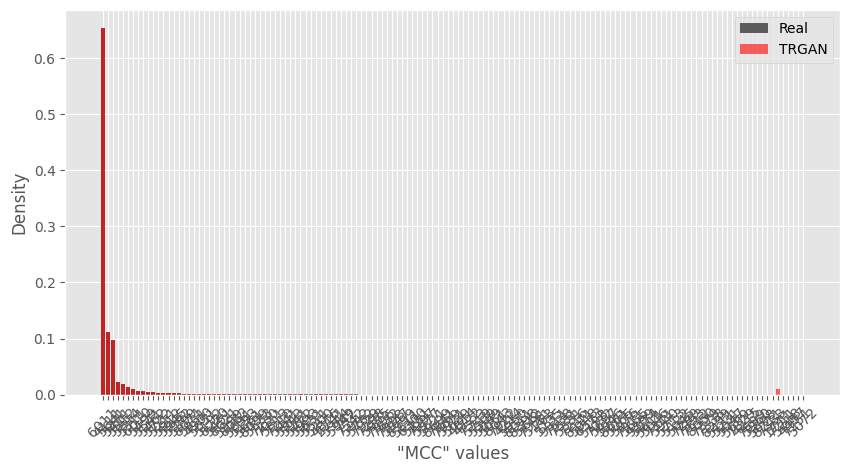

In [142]:
plot_hist_onehot(data, synth_df, mcc_name)

In [168]:
def evaluate_categorical(data_array, index, mcc_name):
    data_array = copy.deepcopy(data_array)
    
    if data_array[0][mcc_name].dtype == 'int' or data_array[0][mcc_name].dtype == 'float':
        tv_values = list(map(lambda x: round(TVComplement.compute(real_data=data_array[0][mcc_name], synthetic_data=x[mcc_name]), 3), data_array))
    
        # cont_sim_value = list(map(lambda x: ContingencySimilarity.compute(real_data=data_array[0][data_cont_array], synthetic_data=x[data_cont_array]), data_array))
        val_counts = list(map(lambda x: round(int(x[mcc_name].value_counts().shape[0])), data_array))

        js_divergence = list(map(lambda x: round(jensenshannon(data_array[0][mcc_name], x[mcc_name]), 5), data_array))

        res_df = pd.DataFrame(np.array([tv_values, val_counts, js_divergence]).T,\
                            columns=['Total Variation', 'Values count', 'D_JS'], index=index)
        
    elif data_array[0][mcc_name].dtype == 'object':
        data_array_le = []
        le2 = LabelEncoder()
        
        data_array[0][mcc_name] = le2.fit_transform(data_array[0][mcc_name])
        data_array_le.append(data_array[0])
        
        for df in data_array[1:]:
            df[mcc_name] = le2.transform(df[mcc_name])
        
            
            data_array_le.append(df)
        
        tv_values = list(map(lambda x: round(TVComplement.compute(real_data=data_array_le[0][mcc_name], synthetic_data=x[mcc_name]), 3), data_array_le))
        val_counts = list(map(lambda x: round(int(x[mcc_name].value_counts().shape[0])), data_array_le))

        js_divergence = list(map(lambda x: round(jensenshannon(data_array_le[0][mcc_name], x[mcc_name]), 5), data_array_le))

        res_df = pd.DataFrame(np.array([tv_values, val_counts, js_divergence]).T,\
                            columns=['Total Variation', 'Values count', 'D_JS'], index=index)

    return res_df

In [169]:
evaluate_categorical([data, synth_df], ['Real', 'TRGAN'], mcc_name)

,Total Variation,Values count,D_JS
Real,1.000,139.0,0.00000
TRGAN,0.987,81.0,0.29334


In [39]:
def evaluate(num_exp = 31):
    epochs = tqdm(range(num_exp))
    stats_num = []
    stats_cat = []
    
    for _ in epochs:
        X_emb, X_oh, cond_vector, synth_date, scaler_cat, scaler_onehot, scaler_num, cv_params, scaler, round_array = \
                trgan.embeddings(data, cat_feat_names, num_feat_names, onehot_cols, date_feature, time_feature, client_id, latent_dim, device=DEVICE, load=False, epochs=40)

        dim_noise = 20
        generator, supervisor, _ = trgan.train(X_emb, cond_vector, latent_dim, dim_noise, epochs=30, load=False)

        synth_data_arr = []
        for _ in range(num_exp):
            n_samples = len(X_emb[:])
            synth_data, synth_date, _ = sample(n_samples, generator, supervisor, dim_noise, cond_vector, X_emb, cv_params['encoder'], data,\
                                                    date_feature, client_id, cv_params=cv_params, device=DEVICE)
            
            synth_data_arr.append(synth_data)
    
        synth_data = np.sum(synth_data_arr, axis=0)/num_exp
        synth_data = scaler.inverse_transform(synth_data)
        synth_df = inverse_transform(synth_data, latent_dim, X_oh.columns, scaler_onehot, scaler_cat, scaler_num, cat_feat_names,
                                mcc_name, num_feat_names, True, synth_date, time_feature, round_array)
            
        stats_num.append(evaluate_numerical([data['AMOUNT_EQ'], synth_df['AMOUNT_EQ']], ['Real', 'TRGAN']))
        stats_cat.append(evaluate_categorical([data, synth_df], ['Real', 'TRGAN'], mcc_name))
        
    return stats_num, stats_cat

In [45]:
stats_num, stats_cat = evaluate(2)

Loss E_num: 0.0001307160418946296: 100%|██████████| 40/40 [00:27<00:00,  1.45it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000129441: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]
Discriminator Loss: -0.04812 || Discriminator 2 Loss: -0.00611 || Generator Loss: 0.03715 || Supervisor Loss: 0.02159: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]
Loss E_num: 3.55320553353522e-05: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000105158: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]
Discriminator Loss: -0.04823 || Discriminator 2 Loss: -0.00068 || Generator Loss: 0.01457 || Supervisor Loss: 0.00854: 100%|██████████| 30/30 [00:54<00:00,  1.81s/it]
Loss E_num: 0.00012222715304233134: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000140208: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]
Discriminator Loss: -0.05029 || Discriminator 2 Loss: -0.00163 || Generator Loss: 0.03056 || Supervisor Loss: -0.00272: 100%|██████████| 30/30 [00:54<00:00,  1.81s/it]
Loss E_num: 0.0001384254574077204: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000336281: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]
Discriminator Loss: -0.04990 || Discriminator 2 Loss: -0.00256 || Generator Loss: 0.01317 || Supervisor Loss: 0.03159: 100%|██████████| 30/30 [00:54<00:00,  1.81s/it]
Loss E_num: 0.00010921240755124018: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000280132: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]
Discriminator Loss: -0.04924 || Discriminator 2 Loss: -0.00257 || Generator Loss: 0.02980 || Supervisor Loss: -0.00408: 100%|██████████| 30/30 [00:55<00:00,  1.84s/it]
Loss E_num: 0.00012819483526982367: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000337254: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]
Discriminator Loss: -0.05001 || Discriminator 2 Loss: -0.00230 || Generator Loss: 0.03082 || Supervisor Loss: -0.00170: 100%|██████████| 30/30 [00:57<00:00,  1.91s/it]
Loss E_num: 0.0001452440774301067: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000287242: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]
Discriminator Loss: -0.04905 || Discriminator 2 Loss: -0.00443 || Generator Loss: -0.00047 || Supervisor Loss: -0.01289: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]
Loss E_num: 0.00012883491581305861: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000203561: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]
Discriminator Loss: -0.04836 || Discriminator 2 Loss: -0.00460 || Generator Loss: 0.03749 || Supervisor Loss: 0.02250: 100%|██████████| 30/30 [00:56<00:00,  1.88s/it]
Loss E_num: 0.00013019688776694238: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000228778: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]
Discriminator Loss: -0.04708 || Discriminator 2 Loss: -0.00290 || Generator Loss: 0.03681 || Supervisor Loss: 0.02178: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]
Loss E_num: 9.141322516370565e-05: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000324760: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]
Discriminator Loss: -0.04970 || Discriminator 2 Loss: -0.00562 || Generator Loss: 0.00158 || Supervisor Loss: -0.00689: 100%|██████████| 30/30 [00:59<00:00,  1.97s/it]
Loss E_num: 0.0001283398160012439: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000171381: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]
Discriminator Loss: -0.04846 || Discriminator 2 Loss: -0.00376 || Generator Loss: -0.00149 || Supervisor Loss: -0.01549: 100%|██████████| 30/30 [00:54<00:00,  1.83s/it]
Loss E_num: 0.00013896040036343038: 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000206537: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]
Discriminator Loss: -0.04973 || Discriminator 2 Loss: -0.00370 || Generator Loss: 0.00024 || Supervisor Loss: -0.01131: 100%|██████████| 30/30 [00:59<00:00,  1.98s/it]
Loss E_num: 0.0001388164673699066: 100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000157798: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]
Discriminator Loss: -0.04888 || Discriminator 2 Loss: -0.00190 || Generator Loss: -0.00057 || Supervisor Loss: -0.01309: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]
Loss E_num: 0.00013707821199204773: 100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000104236: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]
Discriminator Loss: -0.04897 || Discriminator 2 Loss: -0.00399 || Generator Loss: 0.03910 || Supervisor Loss: 0.02714: 100%|██████████| 30/30 [01:01<00:00,  2.05s/it]
Loss E_num: 0.00011929037282243371: 100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


Optimizing poisson intensity...


Loss E_cv: 0.000099512: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]
Discriminator Loss: -0.05057 || Discriminator 2 Loss: -0.00580 || Generator Loss: 0.03261 || Supervisor Loss: 0.02356: 100%|██████████| 30/30 [00:57<00:00,  1.91s/it]
100%|██████████| 15/15 [1:25:20<00:00, 341.40s/it]


In [182]:
statistics = {'mean': [], 'std': [], 'kurt': [], 'skew': [], 'js': [],
              'wd': [], 'js_cat': [], 'tv': [], 'counts': []}

for df in stats_num:
    statistics['mean'].append(df['Mean']['TRGAN'])
    statistics['std'].append(df['Std']['TRGAN'])
    statistics['kurt'].append(df['Kurtosis']['TRGAN'])
    statistics['skew'].append(df['Skewness']['TRGAN'])
    statistics['js'].append(df['D_JS']['TRGAN'])
    statistics['wd'].append(df['Wassertein distance']['TRGAN'])
    
for df in stats_cat:
    statistics['js_cat'].append(df['D_JS']['TRGAN'])
    statistics['tv'].append(df['Total Variation']['TRGAN'])
    statistics['counts'].append(df['Values count']['TRGAN'])


z_critical = sts.norm.ppf(q = 1 - 0.05/2)

pd.DataFrame([
    [f'{round(np.mean(statistics["mean"]), 3)} +- {round(np.std(statistics["mean"], ddof=1), 2)}'
     f' (+- {np.around(z_critical * (np.std(statistics["mean"],ddof=1) / np.sqrt(len(statistics["mean"]))), 2)})',
     
    f'{round(np.mean(statistics["std"]), 3)} +- {round(np.std(statistics["std"], ddof=1), 2)}'
    f' (+- {np.around(z_critical * (np.std(statistics["std"],ddof=1) / np.sqrt(len(statistics["std"]))), 2)})',
    
    f'{round(np.mean(statistics["kurt"]), 3)} +- {round(np.std(statistics["kurt"], ddof=1), 2)}'
    f' (+- {np.around(z_critical * (np.std(statistics["kurt"],ddof=1) / np.sqrt(len(statistics["kurt"]))), 2)})',
    
    f'{round(np.mean(statistics["skew"]), 3)} +- {round(np.std(statistics["skew"], ddof=1), 2)}'
    f' (+- {np.around(z_critical * (np.std(statistics["skew"],ddof=1) / np.sqrt(len(statistics["skew"]))), 2)})',
    
    f'{round(np.mean(statistics["js"]), 5)} +- {round(np.std(statistics["js"], ddof=1), 5)}'
    f' (+- {np.around(z_critical * (np.std(statistics["js"],ddof=1) / np.sqrt(len(statistics["js"]))), 5)})',
    
    f'{round(np.mean(statistics["wd"]), 4)} +- {round(np.std(statistics["wd"], ddof=1), 3)}'
    f' (+- {np.around(z_critical * (np.std(statistics["wd"],ddof=1) / np.sqrt(len(statistics["wd"]))), 3)})',
    
    f'{round(np.mean(statistics["js_cat"]), 5)} +- {round(np.std(statistics["js_cat"], ddof=1), 5)}'
    f' (+- {np.around(z_critical * (np.std(statistics["js_cat"],ddof=1) / np.sqrt(len(statistics["js_cat"]))), 5)})',
    
    f'{round(np.mean(statistics["tv"]), 3)} +- {round(np.std(statistics["tv"], ddof=1), 2)}'
    f' (+- {np.around(z_critical * (np.std(statistics["tv"],ddof=1) / np.sqrt(len(statistics["tv"]))), 2)})',
    
    f'{round(np.mean(statistics["counts"]))} +- {round(np.std(statistics["counts"], ddof=1))}'
    f' (+- {round(z_critical * (np.std(statistics["counts"],ddof=1) / np.sqrt(len(statistics["counts"]))))})'
    
    ],
              ], index=['TRGAN'], columns=['MEAN', 'STD', 'KURTOSIS', 'SKEWNESS', 'D_JS', 'WD', 'D_JS_cat', 'TV', 'Value counts'])

,MEAN,STD,KURTOSIS,SKEWNESS,D_JS,WD,D_JS_cat,TV,Value counts
TRGAN,2.1 +- 0.0 (+- 0.0),0.2 +- 0.0 (+- 0.0),0.127 +- 0.37 (+- 0.19),-0.907 +- 0.09 (+- 0.04),0.00559 +- 0.001 (+- 0.00051),0.012 +- 0.004 (+- 0.002),0.2892 +- 0.004 (+- 0.00203),0.039 +- 0.02 (+- 0.01),96 +- 10 (+- 5)


In [185]:
synth_df['AMOUNT_EQ']

0        8.956747
1        7.737627
2        8.341146
3        8.320096
4        7.075531
           ...   
99263    8.300238
99264    5.218935
99265    8.473362
99266    8.252944
99267    6.780883
Name: AMOUNT_EQ, Length: 99268, dtype: float64

In [187]:
onehot_cols

['MCC', 'OpType', 'NAME', 'PaymentSystem', 'ISOWNTERMINAL']

In [188]:
data['OpType'].value_counts()

OpType
Снятие наличных      65353
Оплата               33507
Возврат                210
Перевод                145
Внесение наличных       48
Отмена операции          5
Name: count, dtype: int64

In [189]:

synth_df['OpType'].value_counts()

OpType
Снятие наличных      65353
Оплата               33507
Возврат                211
Перевод                145
Внесение наличных       48
Отмена операции          4
Name: count, dtype: int64

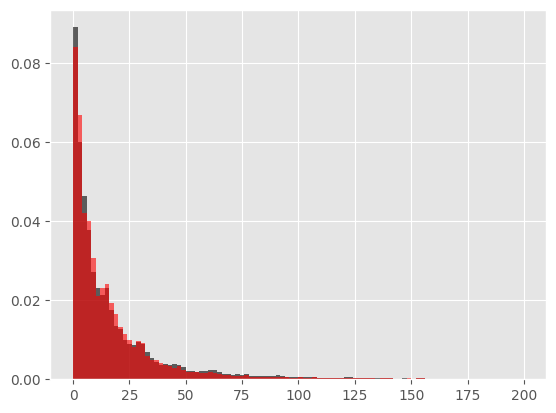

In [204]:
plt.hist(np.hstack(cv_params['deltas_real']), alpha=0.6, bins=np.arange(-1, 200, 2) + 1, label='Real', density=True, color='black')
plt.hist(np.hstack(cv_params['deltas_synth']), alpha=0.6, bins=np.arange(-1, 200, 2) + 1, label='Real', density=True, color='red')
plt.show()

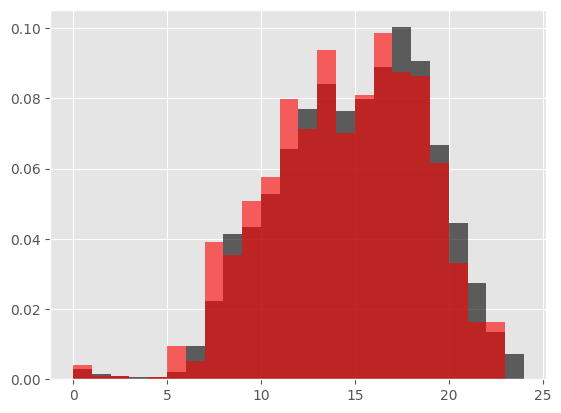

In [191]:
plt.hist(data[time_feature].dt.hour.values, alpha=0.6, bins=np.arange(-1, 24, 1) + 1, label='Real', density=True, color='black')
plt.hist(pd.to_datetime(synth_df[time_feature]).dt.hour.values, alpha=0.6, bins=np.arange(-1, 24, 1) + 1, label='Real', density=True, color='red')
plt.show()

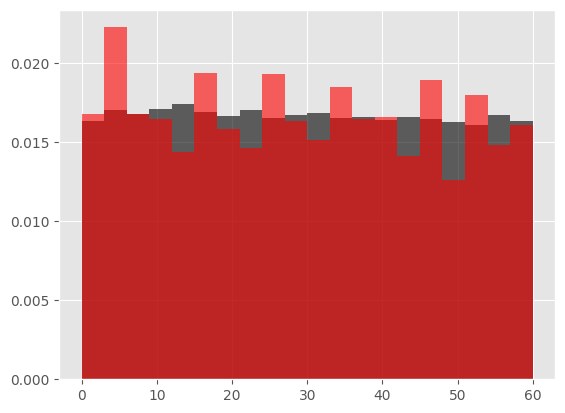

In [201]:
plt.hist(data[time_feature].dt.minute.values, alpha=0.6, bins=np.arange(-1, 60, 3) + 1, label='Real', density=True, color='black')
plt.hist(pd.to_datetime(synth_df[time_feature]).dt.minute.values, alpha=0.6, bins=np.arange(-1, 60, 3) + 1, label='Real', density=True, color='red')
plt.show()

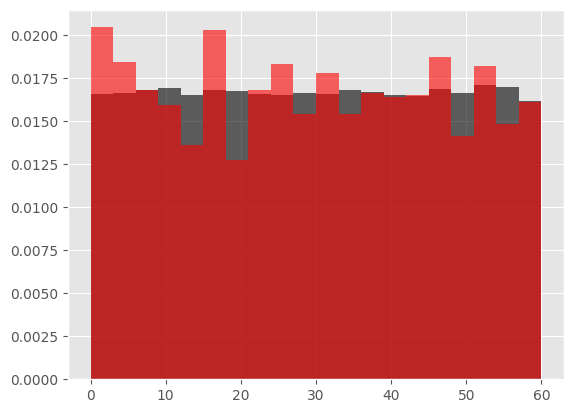

In [202]:
plt.hist(data[time_feature].dt.second.values, alpha=0.6, bins=np.arange(-1, 60, 3) + 1, label='Real', density=True, color='black')
plt.hist(pd.to_datetime(synth_df[time_feature]).dt.second.values, alpha=0.6, bins=np.arange(-1, 60, 3) + 1, label='Real', density=True, color='red')
plt.show()

In [194]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)

pca_real = pca.fit_transform(X_emb1)
pca_synth = pca.transform(synth_data)

In [195]:
# pca = TSNE(n_components=2)
# pca_synth = pca.fit_transform(synth_data)

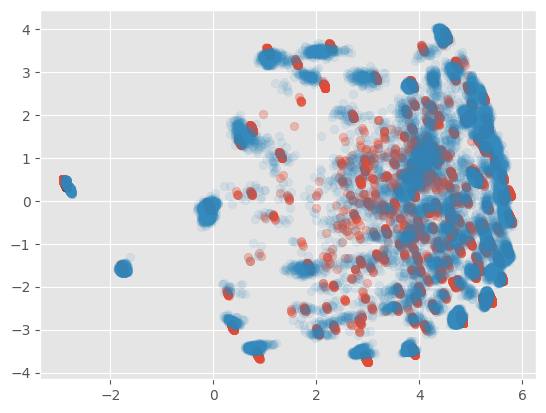

In [196]:
plt.scatter(pca_real[:, 0], pca_real[:, 1], alpha=0.3)
plt.scatter(pca_synth[:, 0], pca_synth[:, 1], alpha=0.1)

plt.show()